# 1. Introdução e Importação de Dados
Este notebook demonstra uma análise multivariada básica usando o dataset Titanic (titanic3.csv).
Objetivos: limpeza e tratamento dos dados, exploração descritiva, análise de correlações e aplicação de técnicas multivariadas (agrupamento via K-Means).
code
#VSC-797d8401
python
# Estatísticas descritivas detalhadas e diagnóstico de distribuição
import seaborn as sns
code
#VSC-797d8401
python
# Estatísticas descritivas detalhadas e diagnóstico de distribuição
import seaborn as sns

# Selecionar colunas numéricas
num_cols = dados_titanic1.select_dtypes(include=['number']).columns.tolist()

# Agregar estatísticas úteis
stats = dados_titanic1[num_cols].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T
stats['skew'] = dados_titanic1[num_cols].skew().values
stats['kurtosis'] = dados_titanic1[num_cols].kurt().values
display(stats)

# Detectar outliers por IQR para cada coluna
outliers_summary = []
for col in num_cols:
    q1 = dados_titanic1[col].quantile(0.25)
    q3 = dados_titanic1[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = dados_titanic1[(dados_titanic1[col] < lower) | (dados_titanic1[col] > upper)][col].shape[0]
    outliers_summary.append([col, n_outliers, lower, upper])
outliers_df = pd.DataFrame(outliers_summary, columns=['col', 'n_outliers', 'lower', 'upper'])
display(outliers_df)

# Histograma e boxplot para colunas chaves (idade, tarifa)
cols_plot = ['idade', 'tarifa']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(dados_titanic1[cols_plot[0]].dropna(), kde=True, ax=axes[0,0]); axes[0,0].set_title('Histograma - ' + cols_plot[0])
sns.boxplot(x=dados_titanic1[cols_plot[0]].dropna(), ax=axes[0,1]); axes[0,1].set_title('Boxplot - ' + cols_plot[0])
sns.histplot(dados_titanic1[cols_plot[1]].dropna(), kde=True, ax=axes[1,0]); axes[1,0].set_title('Histograma - ' + cols_plot[1])
sns.boxplot(x=dados_titanic1[cols_plot[1]].dropna(), ax=axes[1,1]); axes[1,1].set_title('Boxplot - ' + cols_plot[1])
plt.tight_layout(); plt.show()

# Análise rápida de skew/kurtosis e sugestão de transformação
for col in cols_plot:
    s = dados_titanic1[col].dropna()
    sk = s.skew()
    kt = s.kurt()
    print(f'{col}: skew={sk:.3f}, kurtosis={kt:.3f}')
    if sk > 1:
        print('    -> Assimetria forte positiva: considerar log1p, winsorize ou transformação de potência')
    elif sk < -1:
        print('    -> Assimetria forte negativa: considerar transformação de potência ou revisar dados/erros')
    else:
        print('    -> Assimetria moderada/baixa: normalmente a escala pode ser mantida (ou padronizar)')

outliers_summary = []
for col in num_cols:
    q1 = dados_titanic1[col].quantile(0.25)
    q3 = dados_titanic1[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = dados_titanic1[(dados_titanic1[col] < lower) | (dados_titanic1[col] > upper)][col].shape[0]
    outliers_summary.append([col, n_outliers, lower, upper])
outliers_df = pd.DataFrame(outliers_summary, columns=['col', 'n_outliers', 'lower', 'upper'])
display(outliers_df)

# Histograma e boxplot para colunas chaves (idade, tarifa)
cols_plot = ['idade', 'tarifa']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(dados_titanic1[cols_plot[0]].dropna(), kde=True, ax=axes[0,0]); axes[0,0].set_title('Histograma - ' + cols_plot[0])
sns.boxplot(x=dados_titanic1[cols_plot[0]].dropna(), ax=axes[0,1]); axes[0,1].set_title('Boxplot - ' + cols_plot[0])
sns.histplot(dados_titanic1[cols_plot[1]].dropna(), kde=True, ax=axes[1,0]); axes[1,0].set_title('Histograma - ' + cols_plot[1])
sns.boxplot(x=dados_titanic1[cols_plot[1]].dropna(), ax=axes[1,1]); axes[1,1].set_title('Boxplot - ' + cols_plot[1])
plt.tight_layout(); plt.show()

# Análise rápida de skew/kurtosis e sugestão de transformação
for col in cols_plot:
    s = dados_titanic1[col].dropna()
    sk = s.skew()
    kt = s.kurt()
    print(f'


















evitar problemas com valores zero ou negativos.> ⚠️ Observação: se usar `log_transform=True`, verifique que os dados sejam não-negativos; a função faz um ajuste automático paraExemplo: `X_scaled, scaler = convert_to_same_units(dados_titanic1, ['idade','tarifa'], method='zscore', return_scaler=True)`estiverem centrados em zero, ou para dados esparsos.`method='minmax'` para normalização entre 0 e 1, `method='robust'` para robustez a outliers e `method='maxabs'` quando os dados jáe sensíveis à escala, por exemplo K-Means. Use `method='zscore'` quando quiser padronizar para média 0 e desvio padrão 1,Esta função unifica a unidade/escala de um conjunto de colunas selecionadas, adequada para métodos que dependem de distânciasourcemetadata        print('    -> Assimetria moderada/baixa: normalmente a escala pode ser mantida (ou padronizar)')    else:        print('    -> Assimetria forte negativa: considerar transformação de potência ou revisar dados/erros')    elif sk < -1:        print('    -> Assimetria forte positiva: considerar log1p, winsorize ou transformação de potência')    if sk > 1:{col}: skew={sk:.3f}, kurtosis={kt:.3f}')

In [15]:
import numpy as np
import pandas as pd

#noemando o banco de daodos de dados_titanic
dados_titanic = pd.read_csv('titanic3.csv')
#listando as colunas 
#print(dados_titanic.columns)
 
#pclass: classe do passageiro
#survived: sobreviveu (1 = sim, 0 = não)
#name: nome
#sex: sexo
#age: idade
#sibsp: número de irmãos/cônjuges a bordo
#parch: número de pais/filhos a bordo
#ticket: número do bilhete
#fare: tarifa paga
#cabin: cabine
#embarked: porto de embarque
#boat: bote salva-vidas
#body: número do corpo (identificação de vítimas)
#home.dest: destino residencial

#renomeando colunas
dados_titinaic = dados_titanic.rename(columns={
    "pclass": "classe",
    "survived": "sobreviveu",
    "name": "nome",
    "sex": "sexo",
    "age": "idade",
    "sibsp": "irmaos/conjuges_a_bordo",
    "parch": "pais/filhos_a_bordo",
    "ticket": "bilhete",
    "fare": "tarifa",
    "cabin": "cabine",
    "embarked": "embarque",
    "boat": "bote_salva_vidas",
    "body": "mortos_identificados",
    "home.dest": "destino_residencial"
}, inplace=True)

#convertendo as caolunas para o tipo de dados
dados_titanic1 = dados_titanic.astype({"idade": float,
                                        "sobreviveu": 'category',
                                         'pais/filhos_a_bordo': int,
                                         'irmaos/conjuges_a_bordo': int,
                                         "tarifa": float,
                                          'sexo' : "category",
                                           'classe': 'category',
                                             'bilhete': 'category',
                                                   })

#removendo valores missing (nulos)
dados_titanic1 = dados_titanic1.dropna(subset=["idade", "tarifa"])


### 1.2. Medidas descritivas — tendência central, dispersão e diagnóstico de distribuição
Nesta seção vamos além das estatísticas básicas: explicamos as medidas, como calculá-las, e o que fazer quando encontrarmos assimetria ou outliers.
\n
Principais medidas e fórmulas rápidas:
- Média (mean): (1/n) * Σ x_i — sensível a outliers.
- Mediana (median): posição central; robusta a outliers.
- Variância (var): (1/(n-1)) * Σ (x_i - mean)^2; desvio padrão = sqrt(var).
- Quartis e IQR: Q1 (25%), Q3 (75%), IQR = Q3 - Q1 — útil para detectar outliers (1.5*IQR regra).
- Assimetria (skewness): medidor de simetria. Skew>1 sugere assimetria positiva; Skew<-1, assimetria negativa.
- Curtose (kurtosis): mede o peso das caudas. Curtose alta = caudas pesadas (mais outliers).
\n
Processo recomendado nesta seção:
1) Gerar estatísticas descritivas (mean, median, std, min, max, skew, kurt).
2) Produzir histogramas e boxplots para cada variável numérica (visualizar forma e outliers).
3) Contar outliers por coluna com a regra 1.5 * IQR e avaliar impacto.
4) Dependendo do objetivo: (a) remover outliers extremos; (b) aplicar `log1p`/transformações de potência; (c) usar `winsorize` para limitar caudas.
5) Reavaliar medidas (skew/kurtosis) após transformação para confirmar redução de assimetria.
\n
Observação: Para os passos de modificação (transformar ou excluir), documente sempre a decisão, pois cada escolha pode afetar a interpretabilidade e a validade dos modelos downstream (e.g., clusters ou regressões).

In [16]:
#gerando alguns insights exploratorios
print(dados_titanic1.describe().loc[(["mean", 'std', 'min', "max", "50%"])])

         idade  irmaos/conjuges_a_bordo  pais/filhos_a_bordo     tarifa  \
mean 29.851837                 0.503349             0.421053  36.686080   
std  14.389194                 0.912471             0.840052  55.732533   
min   0.170000                 0.000000             0.000000   0.000000   
max  80.000000                 8.000000             6.000000 512.329200   
50%  28.000000                 0.000000             0.000000  15.750000   

      mortos_identificados  
mean            160.033613  
std              98.082975  
min               1.000000  
max             328.000000  
50%             155.000000  


### 1.3. Gráficos de barras — distribuição média e relativa
Mostramos aqui a distribuição média do número de irmãos/cônjuges por classe (classe 1/2/3) e uma representação relativa (proporção) por faixa de número de irmãos. 
Objetivo: visualizar se passageiros em classes diferentes apresentam perfis familiares distintos (médias e frequências relativas).

Interpretação esperada:
- Se a média de `irmaos/conjuges_a_bordo` é maior em uma classe, isso sugere famílias maiores viajando naquela classe.
- O gráfico de frequência relativa mostra como a distribuição de contagens (0,1,2,...) varia por classe — útil para detectar heterogeneidade em perfis familiares.

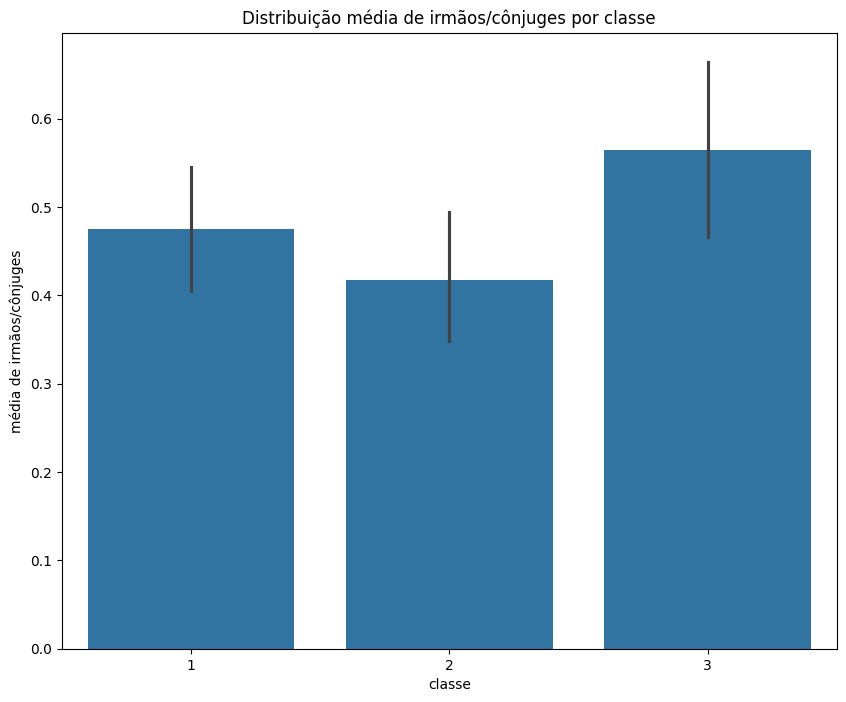

In [12]:
#graficos de barra para visualizar a distribuição das classes, sexo, bilhete e quem sobreviveu
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,8))
sns.barplot(x = "classe", y = "irmaos/conjuges_a_bordo", data=dados_titanic1)
plt.title("Distribuição média de irmãos/cônjuges por classe")
plt.ylabel('média de irmãos/cônjuges')
plt.show()


### 1.3.1. Frequência relativa por classe — irmãos/cônjuges
Aqui mostramos a proporção relativa de cada contagem de `irmãos/cônjuges` por cada classe de passageiros.
Por que isso importa:
- Permite comparar a distribuição completa (não só média) entre classes; por exemplo, duas classes podem ter médias parecidas, mas estruturas de frequência muito diferentes.
- Útil para entender padrões sociais e econômicos: quem viajava em família vs sozinho por classe.

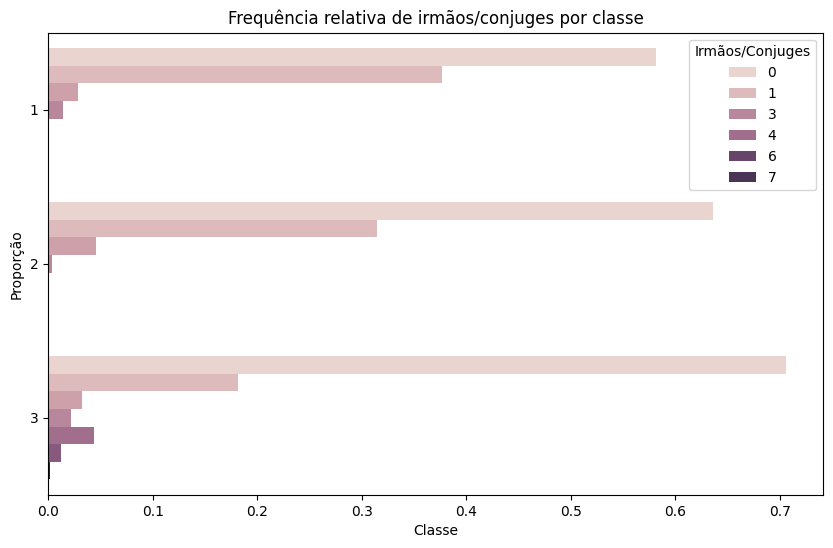

In [13]:
# Gráfico de barras com frequência relativa das classes usando seaborn
frequencia_irmaos = (
    dados_titanic1.groupby('classe', observed= True)['irmaos/conjuges_a_bordo']
    .value_counts(normalize=True)
    .rename('proporcao')
    .reset_index()
)
plt.figure(figsize=(10,6))
sns.barplot(y='classe', x='proporcao', hue='irmaos/conjuges_a_bordo', data=frequencia_irmaos)
plt.title('Frequência relativa de irmãos/conjuges por classe')
plt.ylabel('Proporção')
plt.xlabel('Classe')
plt.legend(title='Irmãos/Conjuges')
#plt.show()

### 1.4. Matriz de Correlação (Pearson) — relações lineares entre variáveis numéricas
Nesta seção calculamos a matriz de correlações Pearson entre as variáveis numéricas do dataset. O objetivo é identificar relações lineares fortes que possam informar próximas etapas (e.g., seleção de variáveis, multicolinearidade, ou insights de causa/efeito possível).

Pontos importantes:
- O coeficiente de Pearson varia de -1 a 1; 1 indica correlação positiva perfeita, -1 correlação negativa perfeita, e 0 nenhuma correlação linear.
- Correlação não implica causalidade: use estes resultados apenas como sinalizadores.
- Atenção a colinearidade: variáveis fortemente correlacionadas podem distorcer modelos que supõem independência entre variáveis (e.g., regressão).

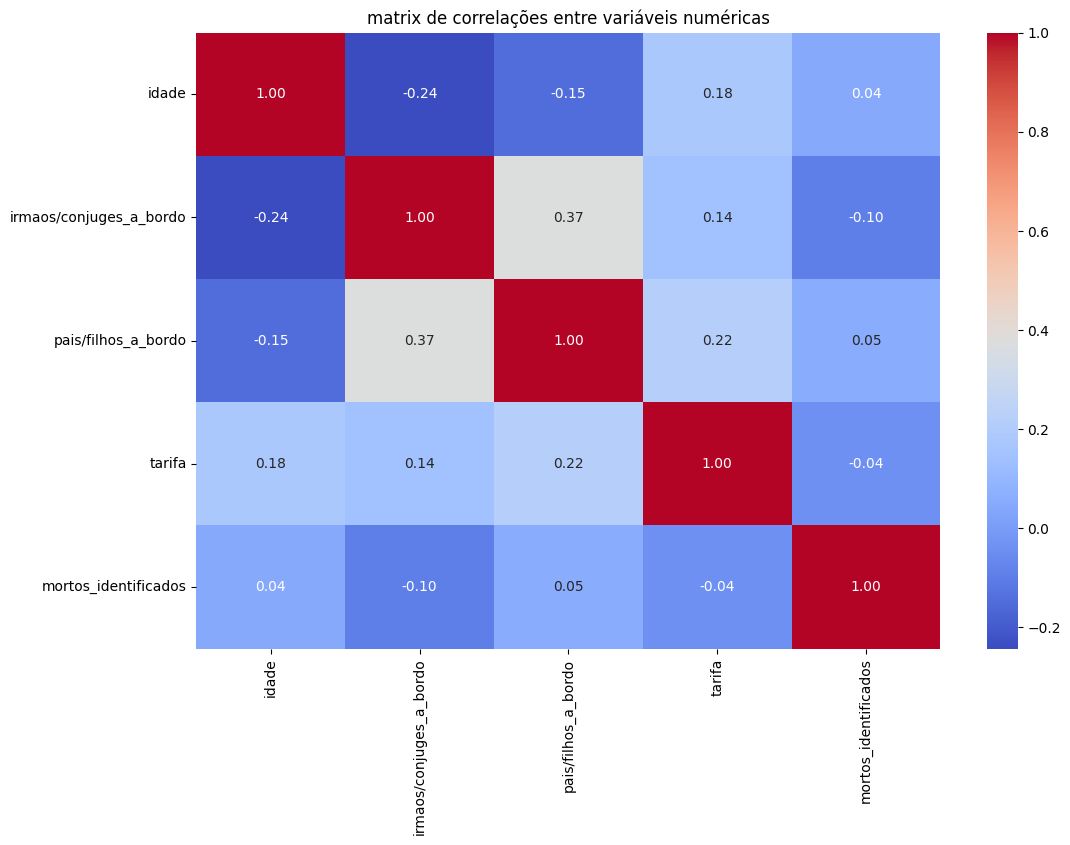

In [17]:
# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
plt.figure(figsize=(12,8))
corr = dados_titanic1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('matrix de correlações entre variáveis numéricas')
plt.show()

### 1.5. Matriz de Pares (Pairplot) — explorar distribuições e relações bivariadas
O pairplot exibe histogramas/distribuições univariadas e gráficos de dispersão para pares de variáveis. É útil para inspecionar tendências, padrões e possíveis relações não-lineares, e para detectar outliers conjuntos que podem influenciar análises posteriores.

Interpretações comuns:
- Verifique se há agrupamentos naturais visíveis com base nas variáveis, que podem indicar segmentos de passageiros.
- Procure por padrões não-lineares que a correlação de Pearson não captaria.
- Combine essa análise com a matriz de correlação (1.4) para formar uma visão completa.

<Figure size 1200x800 with 0 Axes>

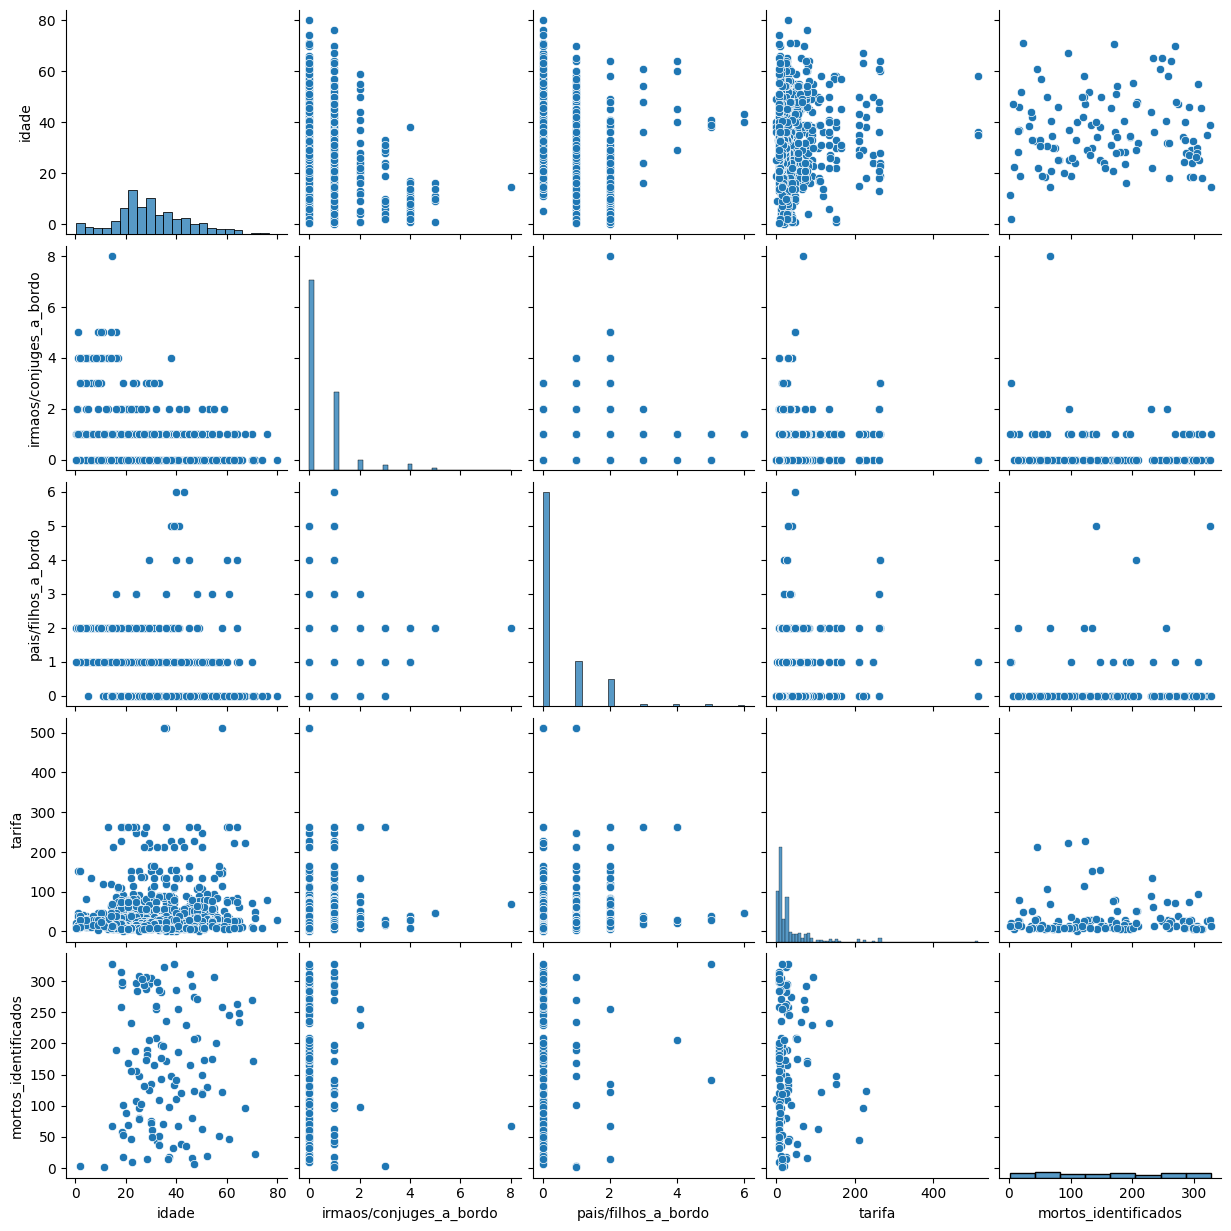

In [18]:
# Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
plt.figure(figsize=(12,8))
sns.pairplot(dados_titanic1)


### 1.6. Testes de Correlação entre Variáveis Numéricas — testes estatísticos e p-valores
Nesta seção usamos o coeficiente de Pearson para medir a correlação entre pares de variáveis numéricas e calculamos o p-valor associado para testar a significância estatística.
O output mostra o coeficiente e o p-valor para cada par — o p-valor indica a probabilidade de observar a correlação sob a hipótese nula (correlação zero).

Interpretação e recomendações:
- Um p-valor baixo (ex.: < 0.05) indica que a correlação observada é estatisticamente significativa.
- Ainda que estatisticamente significativo, verifique o tamanho da correlação (coeficiente) e se faz sentido no contexto de negócio/pesquisa.
- Para variáveis categóricas vs numéricas (não cobertas aqui), considere testes como ANOVA ou correlações ponto-biseriais.

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import itertools
import numpy as np

# Desativar notação científica no pandas
pd.set_option('display.float_format', lambda x: f'{x:.6f}')

# Selecionar somente variáveis numéricas
df_num = dados_titanic1.select_dtypes(include=['number'])

resultados = []

# Gerar todas as combinações de pares de variáveis
for var1, var2 in itertools.combinations(df_num.columns, 2):
    corr, p = pearsonr(df_num[var1], df_num[var2])
    resultados.append([var1, var2, corr, p])

# DataFrame final
tabela_corr = pd.DataFrame(resultados, columns=[
    'Variável 1', 'Variável 2', 'Correlação (Pearson)', 'p-valor'
markdown
#VSC-44bf8e7b
markdown
### 1.2. Medidas descritivas — tendência central, dispersão e diagnóstico de distribuição
Nesta seção vamos além das estatísticas básicas: explicamos as medidas, como calculá-las, e o que fazer quando encontrarmos assimetria ou outliers.

Principais medidas e fórmulas rápidas:
- Média (mean): (1/n) * Σ x_i — sensível a outliers.
- Mediana (median): posição central; robusta a outliers.
- Variância (var): (1/(n-1)) * Σ (x_i - mean)^2; desvio padrão = sqrt(var).
- Quartis e IQR: Q1 (25%), Q3 (75%), IQR = Q3 - Q1 — útil para detectar outliers (1.5*IQR regra).
- Assimetria (skewness): medidor de simetria. Skew>1 sugere assimetria positiva; Skew<-1, assimetria negativa.
- Curtose (kurtosis): mede o peso das caudas. Curtose alta = caudas pesadas (mais outliers).

Processo recomendado nesta seção:
1) Gerar estatísticas descritivas (mean, median, std, min, max, skew, kurt).
2) Produzir histogramas e boxplots para cada variável numérica (visualizar forma e outliers).
3) Contar outliers por coluna com a regra 1.5 * IQR e avaliar impacto.
4) Dependendo do objetivo: (a) remover outliers extremos; (b) aplicar `log1p`/transformações de potência; (c) usar `winsorize` para limitar caudas.
5) Reavaliar medidas (skew/kurtosis) após transformação para confirmar redução de assimetria.

Observação: Para os passos de modificação (transformar ou excluir), documente sempre a decisão, pois cada escolha pode afetar a interpretabilidade e a validade dos modelos downstream (e.g., clusters ou regressões).
cell_type
id
metadata
source
Aqui iniciamos a análise de agrupamento para segmentar passageiros com perfis semelhantes usando K-Means.
Objetivos desta seção:
- Selecionar variáveis relevantes (idade, tarifa, número de irmãos/cônjuges, número de pais/filhos) para caracterizar perfis;
- Padronizar/normalizar variáveis (mesma unidade/escala) para que nenhuma variável domine as distâncias;
- Determinar um número apropriado de clusters (k) usando o método do cotovelo;
- Aplicar K-Means e interpretar os centróides e grupos resultantes.

Considerações práticas:
- Use `convert_to_same_units` para garantir escalonamento consistente;
- Experimente `method='zscore'` e `method='minmax'` para ver diferenças no resultado;
- Interprete os centróides em conjunto com a análise descritiva para descrever cada cluster.

                Variável 1               Variável 2  Correlação (Pearson)  \
0                    idade  irmaos/conjuges_a_bordo             -0.243139   
1                    idade      pais/filhos_a_bordo             -0.150241   
2                    idade                   tarifa              0.178740   
3                    idade     mortos_identificados                   NaN   
4  irmaos/conjuges_a_bordo      pais/filhos_a_bordo              0.374291   
5  irmaos/conjuges_a_bordo                   tarifa              0.141184   
6  irmaos/conjuges_a_bordo     mortos_identificados                   NaN   
7      pais/filhos_a_bordo                   tarifa              0.216723   
8      pais/filhos_a_bordo     mortos_identificados                   NaN   
9                   tarifa     mortos_identificados                   NaN   

   p-valor  
0 0.000000  
1 0.000001  
2 0.000000  
3      NaN  
4 0.000000  
5 0.000005  
6      NaN  
7 0.000000  
8      NaN  
9      NaN  


Antes (amostra):


,idade,tarifa,irmaos/conjuges_a_bordo,pais/filhos_a_bordo
count,1045.000000,1045.000000,1045.000000,1045.000000
mean,29.851837,36.686080,0.503349,0.421053
std,14.389194,55.732533,0.912471,0.840052
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,8.050000,0.000000,0.000000
50%,28.000000,15.750000,0.000000,0.000000
75%,39.000000,35.500000,1.000000,1.000000
max,80.000000,512.329200,8.000000,6.000000


Depois (amostra):


,idade,tarifa,irmaos/conjuges_a_bordo,pais/filhos_a_bordo
count,1045.000000,1045.000000,1045.000000,1045.000000
mean,0.000000,0.000000,-0.000000,0.000000
std,1.000479,1.000479,1.000479,1.000479
min,-2.063774,-0.658568,-0.551897,-0.501462
25%,-0.615467,-0.514059,-0.551897,-0.501462
50%,-0.128758,-0.375833,-0.551897,-0.501462
75%,0.636071,-0.021292,0.544553,0.689511
max,3.486795,8.538475,8.219701,6.644376


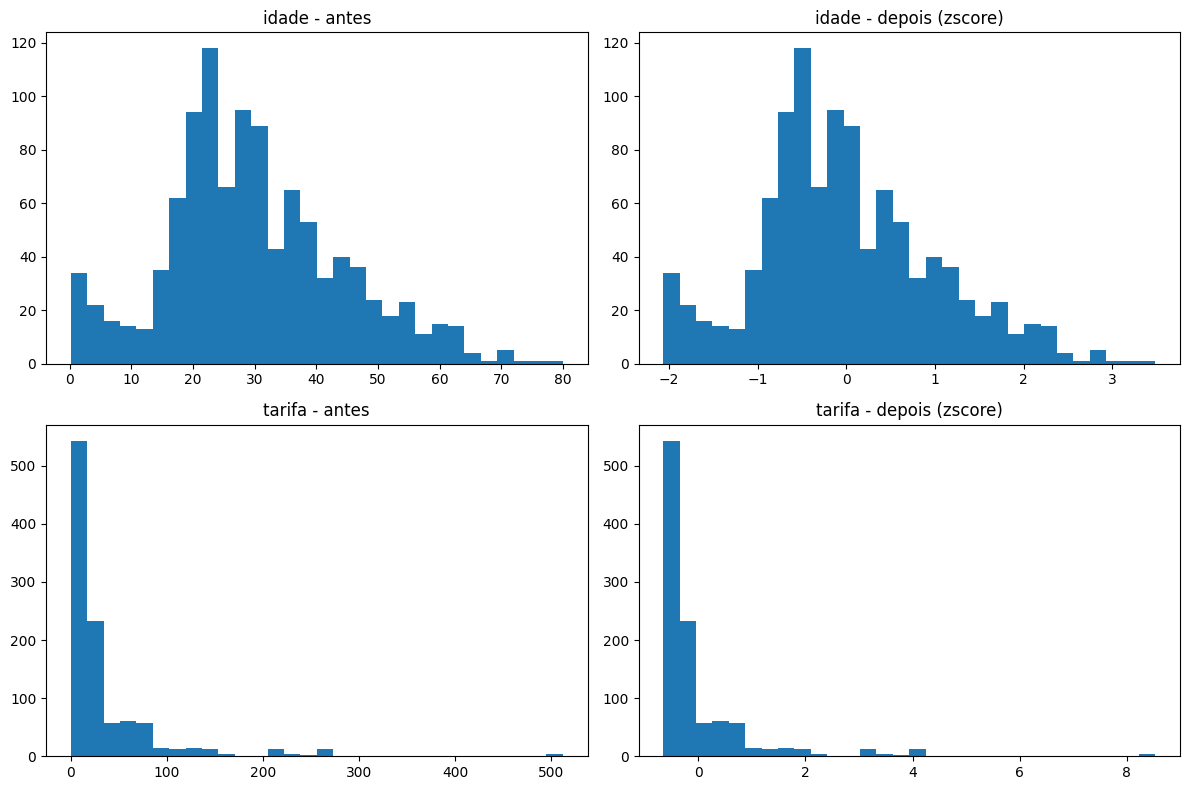

In [ ]:
# Exemplo de uso da função convert_to_same_units
import matplotlib.pyplot as plt
# Selecionar colunas
cols = ['idade','tarifa', "irmaos/conjuges_a_bordo", "pais/filhos_a_bordo"]
X = dados_titanic1[cols]
print('Antes (amostra):')
display(X.describe())

# Aplicar padronização zscore (StandardScaler)
# Também é possível usar a função apenas para retornar um dataset escalado sem alterar o DataFrame original:
X_scaled_df, scaler = convert_to_same_units(dados_titanic1, cols, method='zscore', return_scaler=True)
print('Depois (amostra):')
display(X_scaled_df.describe())

# Histogramas antes / depois
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes[0,0].hist(X['idade'].dropna(), bins=30); axes[0,0].set_title('idade - antes')
axes[0,1].hist(X_scaled_df['idade'].dropna(), bins=30); axes[0,1].set_title('idade - depois (zscore)')
axes[1,0].hist(X['tarifa'].dropna(), bins=30); axes[1,0].set_title('tarifa - antes')
axes[1,1].hist(X_scaled_df['tarifa'].dropna(), bins=30); axes[1,1].set_title('tarifa - depois (zscore)')
plt.tight_layout(); plt.show()

# Exemplos adicionais:
# X_minmax, scaler = convert_to_same_units(dados_titanic1, cols, method='minmax', return_scaler=True)
# X_log, scaler = convert_to_same_units(dados_titanic1, ['tarifa'], method='minmax', log_transform=True, return_scaler=True)


### Para o algoritmo K-Means `dados_titanic1`
Nesta célula aplicamos o método K-Means (K-Médias) ao dataset `dados_titanic1`. A escolha de `k` é baseada no método do cotovelo, que avalia a inércia (somatório das distâncias ao quadrado até o centróide) para diferentes valores de `k`.
Variáveis usadas: `idade` e `tarifa` (para visualização e formação do cluster), e as outras variáveis escalonadas como `irmaos/conjuges_a_bordo` e `pais/filhos_a_bordo` foram preparadas no dataset para análises políticas posteriores.

Fluxo de passos aplicados aqui:
1) Selecionar as colunas relevantes; 2) Padronizar usando `convert_to_same_units`; 3) Rodar o método do cotovelo para encontrar `k` provável; 4) Treinar K-Means com `k` escolhido; 5) Converter centroides de volta para unidades originais com `inverse_transform`; 6) Visualizar os clusters e interpretar centróides.

Observações: para garantir reprodutibilidade e clareza, usamos `return_scaler=True` para manter o objeto `scaler` que permite converter os centróides de volta para as unidades originais (ex.: tarifa em moeda).

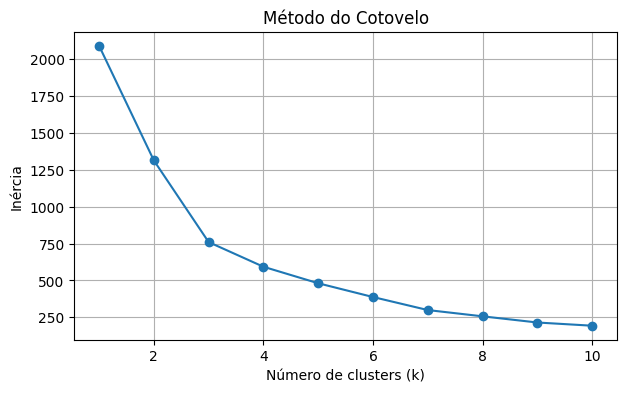


=== CENTROIDES ===
      idade     tarifa
0 21.255629  21.536713
1 45.210210  33.343506
2 38.025000 219.860488


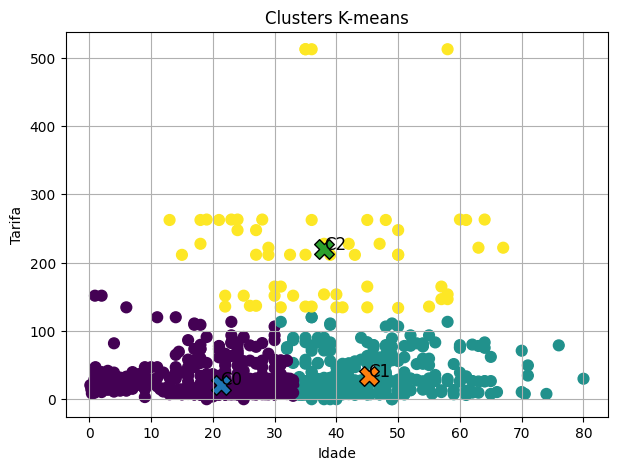


=== GRUPO 0 ===
                                         nome     idade    tarifa  cluster
763   Dean, Miss. Elizabeth Gladys "Millvina"  0.170000 20.575000        0
747   Danbom, Master. Gilbert Sigvard Emanuel  0.330000 14.400000        0
1240          Thomas, Master. Assad Alexander  0.420000  8.516700        0
427                 Hamalainen, Master. Viljo  0.670000 14.500000        0
658             Baclini, Miss. Helene Barbara  0.750000 19.258300        0
...                                       ...       ...       ...      ...
248                        Rowe, Mr. Alfred G 33.000000 26.550000        0
996                        Markun, Mr. Johann 33.000000  7.895800        0
457                    Hunt, Mr. George Henry 33.000000 12.275000        0
1269         Vande Velde, Mr. Johannes Joseph 33.000000  9.500000        0
1222                      Stankovic, Mr. Ivan 33.000000  8.662500        0

[652 rows x 4 columns]

=== GRUPO 1 ===
                                          

In [27]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ===== 3. Método do Cotovelo =====
inertias = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertias, marker="o")
plt.title("Método do Cotovelo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia")
plt.grid(True)
plt.show()

# ===== 4. Escolher manualmente o k (ex: 3) =====
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
dados_titanic1["cluster"] = kmeans.fit_predict(X_scaled)

# ===== 5. Centroides reais =====
centroides = kmeans.cluster_centers_
centroides_reais = scaler_kmeans.inverse_transform(centroides)

print("\n=== CENTROIDES ===")
print(pd.DataFrame(centroides_reais, columns=["idade", "tarifa"]))

# ===== 6. Gráfico dos clusters =====
plt.figure(figsize=(7,5))
plt.scatter(dados_titanic1["idade"],
            dados_titanic1["tarifa"],
            c=dados_titanic1["cluster"],
            s=60)

# adicionar centroides
for i, c in enumerate(centroides_reais):
    plt.scatter(c[0], c[1], marker="X", s=200, edgecolor="black")
    plt.text(c[0], c[1], f"C{i}", fontsize=12)

plt.xlabel("Idade")
plt.ylabel("Tarifa")
plt.title("Clusters K-means")
plt.grid(True)
plt.show()

# ===== 7. Mostrar pessoas por grupo =====
for g in range(k):
    print(f"\n=== GRUPO {g} ===")
    print(dados_titanic1[dados_titanic1["cluster"] == g]
          [["nome","idade","tarifa","cluster"]]
          .sort_values("idade"))
